# Skew-T's
## Requesting Upper Air Data from Siphon and Plotting a Skew-T with MetPy
### Based on <a href = "http://www.unidata.ucar.edu"> Unidata's </a> <i> MetPy Monday </i> \# 15 -17 YouTube links: <br>https://www.youtube.com/watch?v=OUTBiXEuDIU; <br> https://www.youtube.com/watch?v=oog6_b-844Q; <br> https://www.youtube.com/watch?v=b0RsN9mCY5k

### Import the libraries we need

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units, pandas_dataframe_to_unit_arrays
from datetime import datetime, timedelta
import pandas as pd
from siphon.simplewebservice.wyoming import WyomingUpperAir

### Next we use methods from the datetime library to determine the latest time, and then use it to select the most recent date and time that we'll use for our selected Skew-T.

In [3]:
now = datetime.utcnow()

curr_year = now.year
curr_month = now.month
curr_day = now.day
curr_hour = now.hour

print("Current time is: ", now)
print("Current year, month, date, hour: " ,curr_year, curr_month,curr_day,curr_hour)

if (curr_hour > 13) :
    raob_hour = 12
    hr_delta = curr_hour - 12
elif (curr_hour > 1):
    raob_hour = 0
    hr_delta = curr_hour - 0
else:
    raob_hour = 12
    hr_delta = curr_hour + 12

raob_time = now - timedelta(hours=hr_delta)

raob_year = raob_time.year
raob_month = raob_time.month
raob_day = raob_time.day
raob_hour = raob_time.hour

print("Time of RAOB is: ", raob_year, raob_month, raob_day, raob_hour)



Current time is:  2023-03-23 19:36:35.878823
Current year, month, date, hour:  2023 3 23 19
Time of RAOB is:  2023 3 23 12


### Construct a datetime object that we will use in our query to the data server. Note what it looks like.

In [4]:
query_date = datetime(raob_year,raob_month,raob_day,raob_hour)
query_date

datetime.datetime(2023, 3, 23, 12, 0)

### If desired, we can choose a past date and time.

In [5]:
#current = True
current = False

In [86]:
if (current == False):
    query_date = datetime(2013, 5, 20, 18)
    
raob_timeStr = query_date.strftime("%Y-%m-%d %H UTC")
raob_timeTitle = query_date.strftime("%H00 UTC %-d %b %Y")
print(raob_timeStr)
print(raob_timeTitle)

2013-05-20 18 UTC
1800 UTC 20 May 2013


### Select our station and query the data server.

In [87]:
station = 'OUN'

df = WyomingUpperAir.request_data (query_date,station)

### What does the returned data file look like? Well, it looks like a Pandas Dataframe!

In [88]:
df

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,966.0,345,27.4,22.4,185.0,10.0,8.715574e-01,9.961947,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
1,958.0,419,26.2,21.3,185.0,12.0,1.045869e+00,11.954336,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
2,937.6,610,24.1,19.6,185.0,16.0,1.394492e+00,15.939115,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
3,925.0,730,22.8,18.6,185.0,16.0,1.394492e+00,15.939115,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
4,914.0,834,21.6,17.9,193.0,18.0,4.049119e+00,17.538661,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,11.9,30004,-42.5,-59.5,171.0,12.0,-1.877214e+00,11.852260,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
113,11.1,30480,-39.8,-56.8,180.0,11.0,-1.347111e-15,11.000000,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
114,10.9,30601,-39.1,-56.1,200.0,9.0,3.078181e+00,8.457234,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
115,10.6,30785,-39.0,-55.6,230.0,7.0,5.362311e+00,4.499513,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76


### We need to deal with an issue where two levels may be at the same pressure, but different heights.  While rare, it won't allow a parcel path to be calculated later in this notebook:

We can check to see if this is occurring by looking more closely at the data.  Let's look at the last 30 rows of this dataframe (this issue usually occurs near the very top, or lowest pressures, of our sounding data:

In [89]:
df.tail(30)

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
87,43.9,21557,-59.5,-76.5,101.0,17.0,-1.668766e+01,3.243753,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
88,43.3,21641,-59.1,-76.5,100.0,13.0,-1.280250e+01,2.257426,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
89,39.5,22221,-56.7,-76.7,105.0,11.0,-1.062518e+01,2.847009,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
90,39.3,22250,-56.7,-76.7,105.0,11.0,-1.062518e+01,2.847009,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
91,37.5,22555,-56.3,-76.7,85.0,18.0,-1.793150e+01,-1.568803,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
92,32.5,23470,-55.1,-76.7,120.0,13.0,-1.125833e+01,6.500000,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
93,31.0,23761,-54.7,-76.7,96.0,14.0,-1.392331e+01,1.463398,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
94,30.9,23774,-54.8,-76.7,95.0,14.0,-1.394673e+01,1.220180,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
95,30.0,23970,-56.3,-77.3,105.0,20.0,-1.931852e+01,5.176381,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76
96,29.5,24079,-56.6,-77.6,110.0,21.0,-1.973355e+01,7.182423,OUN,72357,2013-05-20 18:00:00,35.18,-97.44,345.0,32.76


If any rows have the same pressure, this will cause an error when we call MetPy's `parcel_path` function. Likely this will get resolved in a future release of MetPy, but for now, let's use a Pandas function to eliminate rows whose pressure is the same as a previous row.

In [90]:
df.drop_duplicates(inplace=True,subset='pressure',ignore_index=True)

In [91]:
df['pressure']

0      966.0
1      958.0
2      937.6
3      925.0
4      914.0
       ...  
112     11.9
113     11.1
114     10.9
115     10.6
116     10.2
Name: pressure, Length: 117, dtype: float64

### As with any Pandas Dataframe, we can select columns, so we do so now for all the relevant variables for our Skew-T. Note now that we are using MetPy's <i>units</i> library to attach units to each variable's array of values.

In [92]:
p = df['pressure'].values * units(df.units['pressure'])

In [93]:
#Let's split up the code above, to see more detail:
df['pressure'].values

array([966. , 958. , 937.6, 925. , 914. , 905.6, 876. , 874.3, 850. ,
       844. , 835. , 825. , 820. , 814. , 813. , 794. , 789. , 785.4,
       781. , 757.6, 730.6, 700. , 653.5, 606. , 586. , 561.1, 539.6,
       524. , 503. , 500. , 492. , 479. , 400. , 390.6, 343.8, 342. ,
       326. , 315. , 302. , 300. , 278. , 250. , 238. , 224. , 219. ,
       218.2, 211. , 202. , 200. , 199. , 191. , 187. , 173. , 159. ,
       152. , 150. , 149.3, 137. , 134. , 129.1, 129. , 122.8, 121. ,
       119. , 118. , 116.9, 107. , 100. ,  88.4,  84.6,  81.2,  79.8,
        74.5,  70. ,  67.4,  63.6,  61. ,  59.2,  58. ,  56.4,  55.3,
        52.6,  50.1,  50. ,  49.7,  48.2,  45.5,  43.9,  43.3,  39.5,
        39.3,  37.5,  32.5,  31. ,  30.9,  30. ,  29.5,  29.4,  28.1,
        25.6,  24.4,  22.5,  22.2,  21.1,  20.2,  20. ,  19.2,  18.6,
        17.5,  16.7,  14. ,  13. ,  11.9,  11.1,  10.9,  10.6,  10.2])

### The University of Wyoming sounding reader includes a <i>units</i> attribute, which produces a Python dictionary of units specific to Wyoming sounding data.  What does it look like? 

In [94]:
df.units

{'pressure': 'hPa',
 'height': 'meter',
 'temperature': 'degC',
 'dewpoint': 'degC',
 'direction': 'degrees',
 'speed': 'knot',
 'u_wind': 'knot',
 'v_wind': 'knot',
 'station': None,
 'station_number': None,
 'time': None,
 'latitude': 'degrees',
 'longitude': 'degrees',
 'elevation': 'meter',
 'pw': 'millimeter'}

In [95]:
#From the dictionary, we can specify pressure units.  In this case, hectopascal (hPa):
units(df.units['pressure'])

1 <Unit('hectopascal')>

In [96]:
#Putting it all together...
p

Magnitude,[966.0 958.0 937.6 925.0 914.0 905.6 876.0 874.3 850.0 844.0 835.0 825.0 820.0 814.0 813.0 794.0 789.0 785.4 781.0 757.6 730.6 700.0 653.5 606.0 586.0 561.1 539.6 524.0 503.0 500.0 492.0 479.0 400.0 390.6 343.8 342.0 326.0 315.0 302.0 300.0 278.0 250.0 238.0 224.0 219.0 218.2 211.0 202.0 200.0 199.0 191.0 187.0 173.0 159.0 152.0 150.0 149.3 137.0 134.0 129.1 129.0 122.8 121.0 119.0 118.0 116.9 107.0 100.0 88.4 84.6 81.2 79.8 74.5 70.0 67.4 63.6 61.0 59.2 58.0 56.4 55.3 52.6 50.1 50.0 49.7 48.2 45.5 43.9 43.3 39.5 39.3 37.5 32.5 31.0 30.9 30.0 29.5 29.4 28.1 25.6 24.4 22.5 22.2 21.1 20.2 20.0 19.2 18.6 17.5 16.7 14.0 13.0 11.9 11.1 10.9 10.6 10.2]
Units,hectopascal


In [97]:
#set this for use later:
p_units=units(df.units['pressure'])

In [98]:
#Set remaining variables and apply units:
Z = df['height'].values * units(df.units['height'])
T = df['temperature'].values * units(df.units['temperature'])
Td = df['dewpoint'].values * units(df.units['dewpoint'])
u = df['u_wind'].values * units(df.units['u_wind'])
v = df['v_wind'].values * units(df.units['v_wind'])

Note: we can also attach units to the various columns using MetPy's `pandas_dataframe_to_unit_arrays` function, as follows:

In [99]:
df = pandas_dataframe_to_unit_arrays(df)

Now that `u` and `v` are *units aware*, we can use one of MetPy's diagnostic routines to calculate the wind speed from the vector's components.

In [100]:
wind_speed = mpcalc.wind_speed(u,v)

Thermodynamic Calculations
--------------------------

Often times we will want to calculate some thermodynamic parameters of a
sounding. The MetPy calc module has many such calculations already implemented!

* **Lifting Condensation Level (LCL)** - The level at which an air parcel's
  relative humidity becomes 100% when lifted along a dry adiabatic path.
* **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
  at the surface temperature/pressure and rising dry adiabatically until
  reaching the LCL, then rising moist adiabatially.

### Calculate the LCL. Note that the units will appear at the end when we print them out!

In [101]:
lclp, lclt = mpcalc.lcl(p[0], T[0], Td[0])
print ('LCL Pressure = ',lclp, 'LCL Temperature = ',lclt)

LCL Pressure =  898.1204116488784 hectopascal LCL Temperature =  21.20810674902293 degree_Celsius


### Calculate the parcel profile. Here, we pass in the array of all pressure values, and specify the first (index 0, remember Python's zero-based indexing) index of the temperature and dewpoint arrays as the starting point of the parcel path.

In [102]:
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0])

### What does the parcel profile look like? Well, it's just an array of all the temperatures of the parcel at each of the pressure levels as it ascends.

In [103]:
parcel_prof

Magnitude,[300.54999999999995 299.836736069287 297.9984533873691 296.8487272786757 295.8358163197983 295.05644136362673 293.5094195326694 293.44313903156024 292.4784144531284 292.23507674173266 291.86610767989407 291.4504236168498 291.2402684900863 290.9860020097667 290.9434008672388 290.1215143454042 289.9011857685468 289.7414748061881 289.5450334913048 288.4766087151251 287.191003299133 285.65872740764667 283.1558615198099 280.34233939886747 279.066409163381 277.39086304660583 275.8576036448139 274.68936363064387 273.03467054462953 272.7900224313626 272.1269039069747 271.0144834771184 263.107272806625 262.0032344351459 255.8051638383004 255.53999671275682 253.08138985632306 251.27761616433335 249.014968927548 248.65351136228398 244.42232921133765 238.28419453684478 235.36454627142766 231.71977245253993 230.3530679624379 230.13113629992822 228.092608762967 225.43800160148027 224.8316436762499 224.52618649798143 222.02701967089027 220.73973817999178 216.02818282321604 210.97686737075804 208.31394816270225 207.53532247872445 207.2608851051571 202.26878160613694 200.9998551352756 198.8808452593406 198.8369823066189 196.0670402737813 195.2436408297194 194.31817106983758 193.8511704996024 193.33412476102717 188.51386451836552 184.90738548863533 178.50915294223518 176.2826164819408 174.22894624928324 173.3654205624139 169.99472173218382 166.9955119420428 165.199334449755 162.48287745114516 160.55669538485063 159.18855295652412 158.25986336317808 157.00001283074573 156.11897915485898 153.90206887627554 151.7756745101752 151.68905691306006 151.42845940838683 150.108342929832 147.65623537881837 146.15370452360236 145.58016964378143 141.8093426692865 141.6038215066642 139.71964225624117 134.1222743264735 132.32368136784336 132.20158327606958 131.0897928484659 130.46180419020527 130.33529562756408 128.66200635513425 125.28194717940171 123.5751969658176 120.74581227735317 120.28362045844925 118.54974569202778 117.08243477236272 116.75004775245421 115.39625154446352 114.3542182920933 112.37971554315175 110.88728802391711 105.43852943768853 103.22947346251209 100.65452646930635 98.67289810660415 98.1616266720661 97.38200422548414 96.31759996448875]
Units,kelvin


### Set the limits for the x- and y-axes so they can be changed and easily re-used when desired.

In [104]:
pTop = 100
pBot = 1050
tMin = -60
tMax = 40

### Since we are plotting a skew-T, define the log-p axis.

In [105]:
logTop = np.log10(pTop)
logBot = np.log10(pBot)
interval = np.logspace(logTop,logBot) * p_units

### This interval will tend to oversample points near the top of the atmosphere relative to the bottom. One effect of this will be that wind barbs will be hard to read, especially at higher levels. Use a resampling method from NumPy to deal with this.

In [106]:
idx = mpcalc.resample_nn_1d(p, interval)

### Now we are ready to create our skew-T. Plot it and save it as a PNG file.

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Note:</p>
    Annoyingly, when specifying the color of the dry/moist adiabats, and mixing ratio lines, the parameter must be <b>color<i>s</i></b>, not <b>color</b>. In other Matplotlib-related code lines in the cell below where we set the color, such as <code>skew.ax.axvline</code> ,<b> color</b> must be singular.
</div>

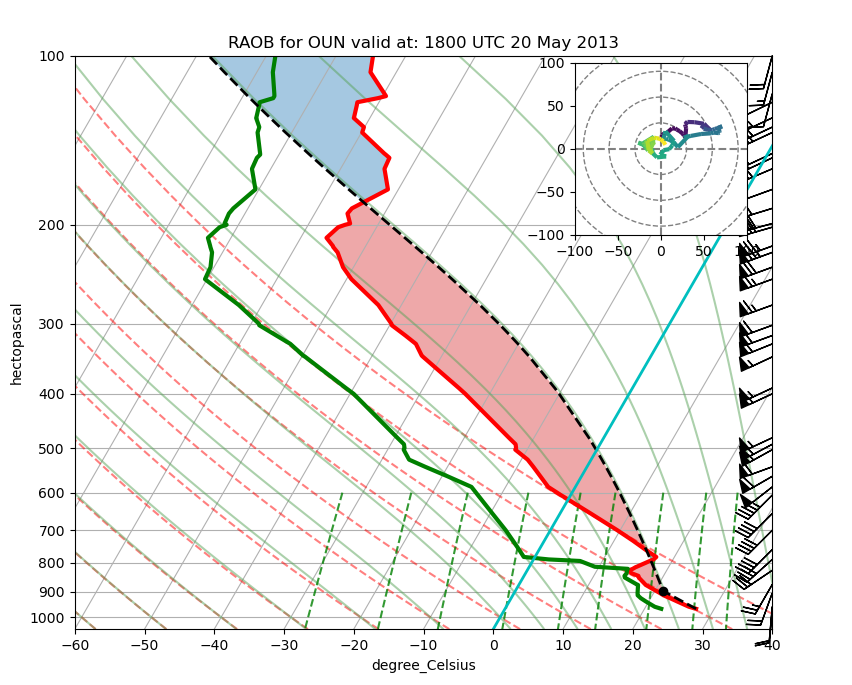

In [107]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=3)
skew.plot(p, Td, 'g', linewidth=3)
skew.plot_barbs(p[idx], u[idx], v[idx])
skew.ax.set_ylim(pBot, pTop)
skew.ax.set_xlim(tMin, tMax)

# Plot LCL as black dot
skew.plot(lclp, lclt, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linestyle='--', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
skew.plot_mixing_lines()

plt.title("RAOB for " + station + ' valid at: '+ raob_timeTitle)

# Create a hodograph
# Create an inset axes object that is 30% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1)
h = Hodograph(ax_hod, component_range=100.)
h.add_grid(increment=30)
#h.plot_colormapped(u, v, df['height'].values)  # Plot a line colored by a parameter
h.plot_colormapped(u, v, df['height'])
plt.savefig (station + raob_timeStr + '_skewt.png')

Here's how the plot would appear if we hadn't done the resampling. Note that the wind barbs are plotted at every level, and are harder to read:

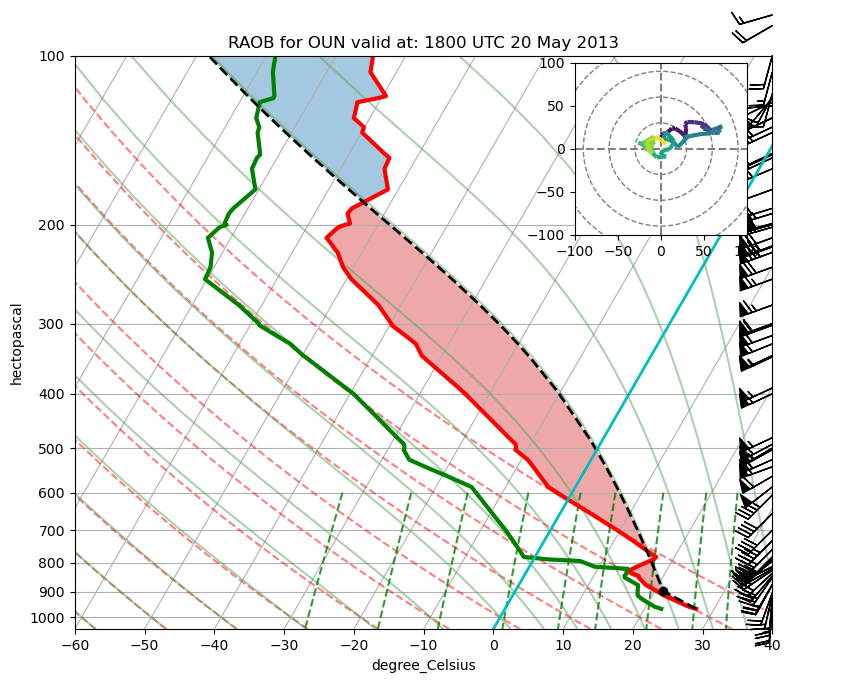

In [109]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=3)
skew.plot(p, Td, 'g', linewidth=3)
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(pBot, pTop)
skew.ax.set_xlim(tMin, tMax)

# Plot LCL as black dot
skew.plot(lclp, lclt, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linestyle='--', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='-', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats(colors='#58a358', linestyle='-')
skew.plot_mixing_lines()

plt.title("RAOB for " + station + ' valid at: '+ raob_timeTitle)

# Create a hodograph
# Create an inset axes object that is 30% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=1)
h = Hodograph(ax_hod, component_range=100.)
h.add_grid(increment=30)
h.plot_colormapped(u, v, df['height'])  # Plot a line colored by a parameter